# Introduction/Business Problem

I want to create a tool that can help me open a franchise of restaurants serving niche, ethnic communities usually located in just one city neighborhood. I would like to show a group of investors why this location and this cuisine makes sense. I first need to make a go/no-go decision based on crime rates in the area. I only want to open a restaurant in a low-crime area. If the crime rate is low, I want to pick a cuisine that is underserved in that community (using Foursquare data). This capstone project will test this tool in Toronto and apply it to the Squirrel Hill neighborhood of Pittsburgh, Pennsyvania, USA.

# Data

The crime rate data to be used for a go/no-go decision will come from [Pittsburgh crime reports](https://www.areavibes.com/pittsburgh-pa/squirrel+hill+north/crime/ "Pittsburgh crime"). 

If the crime rate is below a certain threshhold (likely half of surrounding area), I will use the FourSquare API to plot the frequency of venues. Based on KNN, I'll report the most similar section of Toronto, and identify a restaurant concept.

# Methodology

1. Map the areas of interest, both Toronto and Pittsburgh. 
2. Scrape the above website for Pittsburgh crime data.
    * make a go/no-go decision based on crime
3. Toronto. This work becomes the training data for Pittsburgh
    *     Pull in Toronto neighborhood data from Wikipedia
    *     Pull in the **Foursquare** venue data for those neighborhoods
    *     Cluster the neighborhoods via KMeans clustering
4. Pittsburgh. One neighborhood in Pittsburgh, Squirrel Hill, is the most populated area for the the ethnic community. This is known experientially, not derived via data.
    * Use **KNN** to **build a prediction model** based on the Toronto data. I will classify the Squirrel Hill neighborhood based off of this data.

From the results of the above, I will discuss which venue to open.
    


# Results

Results below follow the outline above, steps 1 - 4. 

## Results - Prework

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import html
print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  20.76 MB/s
geopy-1.18.1-p 100% |################################| Time: 0:00:00  29.38 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  26.97 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  24.61 MB/s
vincent-0.4.4- 100% |###################

## Results (step 1): MAP OF THORNHILL, ONTARIO, CANADA

In [3]:
#Use geopy library to get the latitude and longitude values of Toronto
address_T = 'Thornhill, Ontario, Canada'
geolocator = Nominatim()
location_T = geolocator.geocode(address_T)
latitude_T = location_T.latitude
longitude_T = location_T.longitude
print('The geograpical coordinate of Thornhill, Ontario, Canada are {}, {}.'.format(latitude_T, longitude_T))

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of Thornhill, Ontario, Canada are 43.8161477, -79.4245925.


In [4]:
map_thornhill = folium.Map(location=[latitude_T, longitude_T], zoom_start=13)
folium.Marker([latitude_T, longitude_T],popup=html.escape("Thornhill")).add_to(map_thornhill)
map_thornhill

## Results (step 1): MAP OF PITTSBURGH, PA, USA

In [5]:
address_P = 'squirrel hill south, PA'
geolocator = Nominatim()
location_P = geolocator.geocode(address_P)
latitude_P = location_P.latitude
longitude_P = location_P.longitude
print('The geograpical coordinate of Squirrel Hill South, Pittsburgh, PA, USA are {}, {}.'.format(latitude_P, longitude_P))

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  from ipykernel import kernelapp as app


The geograpical coordinate of Squirrel Hill South, Pittsburgh, PA, USA are 40.4283903, -79.917277.


In [6]:
map_sqhill = folium.Map(location=[latitude_P, longitude_P], zoom_start=13)
folium.Marker([latitude_P, longitude_P],popup=html.escape("Squirrel Hill")).add_to(map_sqhill)
map_sqhill

## Results (step 2): Crime data: do I really want to be there?

In [147]:
import bs4 as bs
import requests
import urllib.request
import pandas as pd
from bs4 import BeautifulSoup
print('done')

done


#### scrape crime data from website

In [148]:
source = urllib.request.urlopen('https://www.areavibes.com/pittsburgh-pa/squirrel+hill+north/crime/').read()
soup = bs.BeautifulSoup(source,'lxml')
table = soup.find('table', attrs={'class':'av-default crime-cmp is-hood'})
table_rows = table.find_all('tr')
res = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)
Pitts = pd.DataFrame(res)
Pitts = pd.DataFrame(res, columns=Pitts.iloc[0])
Pitts = Pitts.drop(Pitts.tail(10).index)
Pitts = Pitts.drop(0)
Pitts

,Statistic,Reportedincidents,Squirrel Hill North/100k people,Pittsburgh/100k people,Pennsylvania/100k people,National/100k people
1,Total crime,"11,536",475 (estimate),"3,771","1,963","2,745"


#### Transform data into number format for calcuation

In [149]:
SQHill100 = Pitts.at[1,'Squirrel Hill North/100k people'] = 475
SQHill100

475

In [150]:
Pitts100 = Pitts.at[1,'Pittsburgh/100k people'] = 3771
Pitts100

3771

In [151]:
CrimeRatio = SQHill100/Pitts100
CrimeRatio

0.12596128347918323

#### Output final decision (GOOD)

In [152]:
if CrimeRatio >= 1:
    print('The crime rate is too high. Go somewhere else.')
elif CrimeRatio > 0.25:
    print('This is a low crime neighborhood. Looks like a good place')
elif CrimeRatio > 0:
    print('This is a very low crime neighborhood. You should definitely look here.')
elif CrimeRatio ==0:
    print('No crime? Is that really true?')

This is a very low crime neighborhood. You should definitely look here.


## Results (part 3). Foursquare & Clustering

#### Toronto web scraping

In [153]:
import bs4 as bs

import requests
import urllib.request
import pandas as pd
from bs4 import BeautifulSoup
print('done')

done


In [154]:
source = urllib.request.urlopen('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').read()
soup = bs.BeautifulSoup(source,'lxml')
table = soup.find('table', attrs={'class':'wikitable sortable'})
table_rows = table.find_all('tr')
res = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)
torontoRaw = pd.DataFrame(res, columns=["Postcode", "Boro", "Neighborhood"])
torontoBoro = torontoRaw[torontoRaw.Boro != 'Not assigned']
torontoBoro.Neighborhood.replace('Not assigned',torontoBoro.Boro,inplace=True)
toronto = pd.DataFrame(torontoBoro.groupby(['Postcode','Boro'])['Neighborhood'].apply(', '.join))
toronto = toronto.reset_index()
url="https://cocl.us/Geospatial_data"
c=pd.read_csv(url)
c.rename(columns={'Postal Code': 'Postcode'}, inplace=True)
toronto_ll = pd.merge(toronto, c, on='Postcode', how='left')
toronto_ll.sort_values(['Neighborhood'])
toronto_ll.head()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,Postcode,Boro,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### Select Toronto neighborhoods

In [155]:
toronto_upd = toronto_ll[toronto_ll['Boro'].isin(['Etobicoke', 'Scarborough', 'East Toronto', 'Downtown Toronto', 'West Toronto', 'Central Toronto', 'East York', 'North York', 'York'])].reset_index(drop=True)
toronto_upd.head()

,Postcode,Boro,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### call Foursquare

In [156]:
# The code was removed by Watson Studio for sharing.

In [157]:
#DEFINE FUNCTION
def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url2).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [158]:
toronto_venues = getNearbyVenues(names=toronto_upd['Neighborhood'],
                                   latitudes=toronto_upd['Latitude'],
                                   longitudes=toronto_upd['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West, Steeles West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The D

In [159]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,100,100,100,100,100,100
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",100,100,100,100,100,100
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",82,82,82,82,82,82
"Alderwood, Long Branch",100,100,100,100,100,100
"Bathurst Manor, Downsview North, Wilson Heights",100,100,100,100,100,100
Bayview Village,100,100,100,100,100,100
"Bedford Park, Lawrence Manor East",100,100,100,100,100,100
Berczy Park,100,100,100,100,100,100


In [160]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

mid = toronto_onehot['Neighborhood']
toronto_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
toronto_onehot.insert(0, 'Neighborhood', mid)

In [161]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()


In [241]:
toronto_grouped.head(2)

,Neighborhood,ATM,Adult Boutique,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Liquor Store,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Adelaide, King, Richmond",0.0,0.01,0.0,0.0,0.0,0.01,0.0,0.01,0.02,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.02,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.06,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.09,0.0,0.01,0.0,0.01,0.03,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.

In [242]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(2)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Italian Restaurant,Theater,Concert Hall,Hotel,Sandwich Place,Restaurant,Pizza Place,French Restaurant
1,Agincourt,Chinese Restaurant,Indian Restaurant,Caribbean Restaurant,Coffee Shop,Sushi Restaurant,Noodle House,Hakka Restaurant,Park,Pizza Place,Pharmacy


#### KMeans clustering

In [164]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
toronto_grouped_clustering.shape

(101, 254)

In [165]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_.shape 

(101,)

In [166]:
toronto_upd.shape

(101, 5)

In [167]:
toronto_upd.head()

,Postcode,Boro,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [168]:
#create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = toronto_upd  #.drop(toronto_lake.index[[98,99,100]]) #work around for a ValueError: Length of values does not match length of index
# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head()

,Postcode,Boro,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,0,Coffee Shop,Zoo Exhibit,Sandwich Place,Pharmacy,Fast Food Restaurant,Pizza Place,Park,Chinese Restaurant,Bank,Fried Chicken Joint
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,4,Zoo Exhibit,Coffee Shop,Park,Pizza Place,Pharmacy,Breakfast Spot,Smoothie Shop,Pub,Sandwich Place,Beer Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4,Coffee Shop,Pizza Place,Pharmacy,Sandwich Place,Bank,Park,Indian Restaurant,Beer Store,Discount Store,Gym
3,M1G,Scarborough,Woburn,43.770992,-79.216917,3,Coffee Shop,Fast Food Restaurant,Sandwich Place,Burger Joint,Park,Pharmacy,Pizza Place,Caribbean Restaurant,Breakfast Spot,Indian Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Indian Restaurant,Sandwich Place,Pizza Place,Caribbean Restaurant,Park,Pharmacy,Burger Joint


### Output of Toronto clusters

##### Cluster 0

In [169]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Boro,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,0,Coffee Shop,Zoo Exhibit,Sandwich Place,Pharmacy,Fast Food Restaurant,Pizza Place,Park,Chinese Restaurant,Bank,Fried Chicken Joint
8,Scarborough,0,Coffee Shop,Sandwich Place,Grocery Store,Park,Beer Store,Pharmacy,Pizza Place,Chinese Restaurant,Gym,Clothing Store
14,Scarborough,0,Chinese Restaurant,Caribbean Restaurant,Bubble Tea Shop,Bakery,Indian Restaurant,Noodle House,Japanese Restaurant,Breakfast Spot,Asian Restaurant,Hakka Restaurant
15,Scarborough,0,Chinese Restaurant,Caribbean Restaurant,Bakery,Bubble Tea Shop,Japanese Restaurant,Asian Restaurant,Sushi Restaurant,Korean Restaurant,Electronics Store,Tea Room
18,North York,0,Chinese Restaurant,Bakery,Caribbean Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Cantonese Restaurant,Coffee Shop,Supermarket,Shopping Mall,Gym / Fitness Center
19,North York,0,Korean Restaurant,Middle Eastern Restaurant,Supermarket,Bakery,Japanese Restaurant,Coffee Shop,Café,Chinese Restaurant,Bagel Shop,Sushi Restaurant
21,North York,0,Korean Restaurant,Coffee Shop,Middle Eastern Restaurant,Café,Supermarket,Bagel Shop,Chinese Restaurant,Furniture / Home Store,Sushi Restaurant,Bubble Tea Shop
26,North York,0,Middle Eastern Restaurant,Japanese Restaurant,Burger Joint,Park,Furniture / Home Store,Gym / Fitness Center,Gym,Cosmetics Shop,Steakhouse,Bakery
31,North York,0,Clothing Store,Coffee Shop,Vietnamese Restaurant,Middle Eastern Restaurant,Liquor Store,Turkish Restaurant,Sushi Restaurant,Dessert Shop,Cosmetics Shop,Bakery
42,East Toronto,0,Coffee Shop,Park,Café,Beach,Pizza Place,Gastropub,Bakery,Breakfast Spot,Brewery,Ice Cream Shop


##### Cluster 1

In [170]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Boro,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Scarborough,1,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Indian Restaurant,Sandwich Place,Pizza Place,Caribbean Restaurant,Park,Pharmacy,Burger Joint
5,Scarborough,1,Coffee Shop,Chinese Restaurant,Burger Joint,Park,Indian Restaurant,Breakfast Spot,Steakhouse,Sushi Restaurant,Gym / Fitness Center,Gym
6,Scarborough,1,Coffee Shop,Park,Middle Eastern Restaurant,Chinese Restaurant,Indian Restaurant,Burger Joint,Gym,Grocery Store,Liquor Store,Sushi Restaurant
7,Scarborough,1,Middle Eastern Restaurant,Coffee Shop,Breakfast Spot,Park,Gastropub,Beach,Bakery,Gym / Fitness Center,Café,Thai Restaurant
10,Scarborough,1,Middle Eastern Restaurant,Indian Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Supermarket,Grocery Store,Gym,Burger Joint,Sushi Restaurant
13,Scarborough,1,Chinese Restaurant,Coffee Shop,Middle Eastern Restaurant,Caribbean Restaurant,Noodle House,Supermarket,Indian Restaurant,Sushi Restaurant,Korean Restaurant,Japanese Restaurant
22,North York,1,Korean Restaurant,Café,Middle Eastern Restaurant,Bakery,Burger Joint,Coffee Shop,Sushi Restaurant,Furniture / Home Store,Japanese Restaurant,Ramen Restaurant
25,North York,1,Middle Eastern Restaurant,Supermarket,Japanese Restaurant,Mediterranean Restaurant,Bakery,Caribbean Restaurant,Burger Joint,Italian Restaurant,Park,General Entertainment
32,North York,1,Clothing Store,Coffee Shop,Vietnamese Restaurant,Grocery Store,Liquor Store,Japanese Restaurant,Cosmetics Shop,Bakery,Men's Store,Furniture / Home Store
33,North York,1,Coffee Shop,Hotel,Italian Restaurant,Restaurant,Burger Joint,Sandwich Place,Grocery Store,Vietnamese Restaurant,Steakhouse,Middle Eastern Restaurant


##### Cluster 2

In [171]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Boro,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Scarborough,2,Beach,Park,Coffee Shop,Breakfast Spot,Café,Pub,Gastropub,Liquor Store,Bakery,Brewery
11,Scarborough,2,Middle Eastern Restaurant,Chinese Restaurant,Indian Restaurant,Coffee Shop,Burger Joint,Supermarket,Caribbean Restaurant,Grocery Store,Italian Restaurant,Falafel Restaurant
12,Scarborough,2,Chinese Restaurant,Indian Restaurant,Caribbean Restaurant,Coffee Shop,Sushi Restaurant,Noodle House,Hakka Restaurant,Park,Pizza Place,Pharmacy
16,Scarborough,2,Zoo Exhibit,Sandwich Place,Fast Food Restaurant,Coffee Shop,Pizza Place,Pharmacy,Grocery Store,Restaurant,Hakka Restaurant,Indian Restaurant
20,North York,2,Burger Joint,Park,Coffee Shop,Bakery,Middle Eastern Restaurant,Café,Japanese Restaurant,Shopping Mall,Steakhouse,Supermarket
27,North York,2,Middle Eastern Restaurant,Supermarket,Bakery,Park,Café,Grocery Store,Ice Cream Shop,Indian Restaurant,Coffee Shop,Gym / Fitness Center
28,North York,2,Coffee Shop,Clothing Store,Bagel Shop,Burger Joint,Café,Bakery,Deli / Bodega,Sushi Restaurant,Liquor Store,Bookstore
29,North York,2,Coffee Shop,Restaurant,Middle Eastern Restaurant,Hotel,Park,Grocery Store,Turkish Restaurant,Furniture / Home Store,Sandwich Place,Smoothie Shop
30,North York,2,Clothing Store,Coffee Shop,Deli / Bodega,Bagel Shop,Cosmetics Shop,Sporting Goods Shop,Dessert Shop,Bakery,Furniture / Home Store,Jewelry Store
34,North York,2,Middle Eastern Restaurant,Café,Park,Bakery,Gym / Fitness Center,Supermarket,Caribbean Restaurant,Warehouse Store,Grocery Store,Sandwich Place


##### Cluster 3

In [172]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Boro,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Scarborough,3,Coffee Shop,Fast Food Restaurant,Sandwich Place,Burger Joint,Park,Pharmacy,Pizza Place,Caribbean Restaurant,Breakfast Spot,Indian Restaurant
17,North York,3,Bakery,Chinese Restaurant,Japanese Restaurant,Caribbean Restaurant,Supermarket,Korean Restaurant,Coffee Shop,Middle Eastern Restaurant,Sushi Restaurant,Burger Joint
24,North York,3,Coffee Shop,Korean Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Grocery Store,Café,Japanese Restaurant,Bagel Shop,Supermarket,Deli / Bodega
36,East York,3,Park,Café,Gastropub,Bakery,Greek Restaurant,Brewery,Pizza Place,Coffee Shop,Indian Restaurant,Beach
40,East York,3,Park,Coffee Shop,Café,Greek Restaurant,Italian Restaurant,Breakfast Spot,Bakery,Pizza Place,Restaurant,BBQ Joint
46,Central Toronto,3,Café,Coffee Shop,Bakery,Park,Sushi Restaurant,Burger Joint,Bagel Shop,Italian Restaurant,French Restaurant,Ice Cream Shop
51,Downtown Toronto,3,Coffee Shop,Café,Park,Farmers Market,Italian Restaurant,Concert Hall,Gastropub,Restaurant,Japanese Restaurant,Bakery
55,Downtown Toronto,3,Coffee Shop,Japanese Restaurant,Hotel,Café,Park,Farmers Market,Restaurant,Theater,Concert Hall,Gastropub
58,Downtown Toronto,3,Coffee Shop,Café,Italian Restaurant,Theater,Concert Hall,Hotel,Sandwich Place,Restaurant,Pizza Place,French Restaurant
70,Downtown Toronto,3,Coffee Shop,Italian Restaurant,Café,Theater,Farmers Market,Hotel,Concert Hall,Park,Restaurant,Sandwich Place


##### Cluster 4

In [173]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Boro,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,4,Zoo Exhibit,Coffee Shop,Park,Pizza Place,Pharmacy,Breakfast Spot,Smoothie Shop,Pub,Sandwich Place,Beer Store
2,Scarborough,4,Coffee Shop,Pizza Place,Pharmacy,Sandwich Place,Bank,Park,Indian Restaurant,Beer Store,Discount Store,Gym
23,North York,4,Coffee Shop,Bakery,Park,Sushi Restaurant,Café,Burger Joint,Supermarket,Bagel Shop,Korean Restaurant,Seafood Restaurant
41,East Toronto,4,Coffee Shop,Café,Park,Italian Restaurant,Pizza Place,Ice Cream Shop,Middle Eastern Restaurant,Japanese Restaurant,Bakery,Hotel
52,Downtown Toronto,4,Coffee Shop,Café,Italian Restaurant,Restaurant,Concert Hall,Theater,Japanese Restaurant,Farmers Market,Gastropub,Vegetarian / Vegan Restaurant
60,Downtown Toronto,4,Coffee Shop,Italian Restaurant,Café,Theater,Farmers Market,Hotel,Concert Hall,Park,Restaurant,Sandwich Place


##### Cluster 5

In [174]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Highland Creek, Rouge Hill, Port Union",4,Zoo Exhibit,Coffee Shop,Park,Pizza Place,Pharmacy,Breakfast Spot,Smoothie Shop,Pub,Sandwich Place,Beer Store
2,"Guildwood, Morningside, West Hill",4,Coffee Shop,Pizza Place,Pharmacy,Sandwich Place,Bank,Park,Indian Restaurant,Beer Store,Discount Store,Gym
23,York Mills West,4,Coffee Shop,Bakery,Park,Sushi Restaurant,Café,Burger Joint,Supermarket,Bagel Shop,Korean Restaurant,Seafood Restaurant
41,"The Danforth West, Riverdale",4,Coffee Shop,Café,Park,Italian Restaurant,Pizza Place,Ice Cream Shop,Middle Eastern Restaurant,Japanese Restaurant,Bakery,Hotel
52,Church and Wellesley,4,Coffee Shop,Café,Italian Restaurant,Restaurant,Concert Hall,Theater,Japanese Restaurant,Farmers Market,Gastropub,Vegetarian / Vegan Restaurant
60,"Design Exchange, Toronto Dominion Centre",4,Coffee Shop,Italian Restaurant,Café,Theater,Farmers Market,Hotel,Concert Hall,Park,Restaurant,Sandwich Place


## Results (step 4) Pittsburgh

#### Target the Squirrel Hill neighborhood of Pittsburgh, and pull in venues via Foursquare

In [175]:
Pittsdf = pd.DataFrame({'Neighborhood':['Squirrel Hill'], 'Neighborhood Latitude':latitude_P, 'Neighborhood Longitude':longitude_P})
Pittsdf

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Squirrel Hill,40.42839,-79.917277


In [176]:
##CALL FUNCTION
pitts_venues = getNearbyVenues(names=Pittsdf['Neighborhood'],
                                   latitudes=Pittsdf['Neighborhood Latitude'],
                                   longitudes=Pittsdf['Neighborhood Longitude']
                                  )

Squirrel Hill


In [177]:
print(pitts_venues.shape)
pitts_venues.head()

(100, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Squirrel Hill,40.42839,-79.917277,Mineo's Pizza,40.432956,-79.923073,Pizza Place
1,Squirrel Hill,40.42839,-79.917277,Frick Park,40.431488,-79.905993,Park
2,Squirrel Hill,40.42839,-79.917277,Dobrá Tea,40.434872,-79.922770,Tea Room
3,Squirrel Hill,40.42839,-79.917277,Chengdu Gourmet,40.429473,-79.922455,Szechuan Restaurant
4,Squirrel Hill,40.42839,-79.917277,The Manor,40.437247,-79.922673,Indie Movie Theater


In [178]:
##SEE COUNT OF EACH ELEMENT IN TABLE
pitts_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Squirrel Hill,100,100,100,100,100,100


In [179]:
##HOW MANY UNIQUE
print('There are {} uniques categories.'.format(len(pitts_venues['Venue Category'].unique())))

There are 66 uniques categories.


In [180]:
##ONE HOT ENCODING FOR K MEANS CLUSTERING
pitts_onehot = pd.get_dummies(pitts_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
pitts_onehot['Neighborhood'] = pitts_venues['Neighborhood'] 
mid = pitts_onehot['Neighborhood']
pitts_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
pitts_onehot.insert(0, 'Neighborhood', mid)
# move neighborhood column to the first column
#fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
#toronto_onehot = toronto_onehot[fixed_columns]
pitts_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Bakery,Bar,Bistro,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Cocktail Bar,Coffee Shop,College Academic Building,Comedy Club,Concert Hall,Cosmetics Shop,Deli / Bodega,Diner,Dive Bar,Fast Food Restaurant,Gift Shop,Golf Course,Grocery Store,Gym,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Ice Cream Shop,Indie Movie Theater,Library,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Museum,New American Restaurant,Noodle House,Park,Pet Store,Pizza Place,Plaza,Pub,Record Shop,Restaurant,Sandwich Place,Shoe Store,Shopping Plaza,Spiritual Center,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Toy / Game Store,Trail,Turkish Restaurant,Women's Store
0,Squirrel Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Squirrel Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Squirrel Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,Squirrel Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,Squirrel Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [181]:
pitts_onehot.shape

(100, 67)

In [182]:
##GROUP 'EM
pitts_grouped = pitts_onehot.groupby('Neighborhood').mean().reset_index()
pitts_grouped

,Neighborhood,Accessories Store,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Bakery,Bar,Bistro,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Cocktail Bar,Coffee Shop,College Academic Building,Comedy Club,Concert Hall,Cosmetics Shop,Deli / Bodega,Diner,Dive Bar,Fast Food Restaurant,Gift Shop,Golf Course,Grocery Store,Gym,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Ice Cream Shop,Indie Movie Theater,Library,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Museum,New American Restaurant,Noodle House,Park,Pet Store,Pizza Place,Plaza,Pub,Record Shop,Restaurant,Sandwich Place,Shoe Store,Shopping Plaza,Spiritual Center,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Toy / Game Store,Trail,Turkish Restaurant,Women's Store
0,Squirrel Hill,0.01,0.01,0.01,0.01,0.02,0.06,0.05,0.01,0.01,0.01,0.01,0.02,0.02,0.01,0.01,0.01,0.04,0.01,0.01,0.02,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.02,0.01,0.02,0.01,0.01,0.01,0.02,0.04,0.01,0.01,0.02,0.02,0.01,0.01,0.01,0.01,0.02,0.01,0.03,0.01,0.04,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.01,0.01,0.02,0.01


#### Create a list of most popular venues for the Squirrel Hill neighborhood in Pittsburgh

In [183]:
P_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
P_neighborhoods_venues_sorted['Neighborhood'] = pitts_grouped['Neighborhood']

for ind in np.arange(pitts_grouped.shape[0]):
    P_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(pitts_grouped.iloc[ind, :], num_top_venues)

P_neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Squirrel Hill,Bakery,Bar,Ice Cream Shop,Coffee Shop,Pizza Place,Park,Grocery Store,Mediterranean Restaurant,New American Restaurant,Liquor Store


###  Results (step 4): Build a prediction model for Squirrel Hill using KNN

In [184]:
trunc_toronto = toronto_merged[['Neighborhood', 'Cluster Labels']]
trunc_toronto.head()

,Neighborhood,Cluster Labels
0,"Rouge, Malvern",0
1,"Highland Creek, Rouge Hill, Port Union",4
2,"Guildwood, Morningside, West Hill",4
3,Woburn,3
4,Cedarbrae,1


#### Build a training dataset using the Toronto clusters

In [185]:
trunc_merge = trunc_toronto.join(toronto_grouped.set_index('Neighborhood'), on='Neighborhood')
trunc_merge.head()

,Neighborhood,Cluster Labels,ATM,Adult Boutique,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Liquor Store,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Rouge, Malvern",0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.020000,0.0,0.000000,0.0,0.00,0.0,0.010000,0.030000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.020000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.000000,0.000000,0.000000,0.0,0.010000,0.0,0.00,0.020000,0.0,0.0,0.0,0.030000,0.01,0.0,0.0,0.0,

In [186]:
list(trunc_merge)

['Neighborhood',
 'Cluster Labels',
 'ATM',
 'Adult Boutique',
 'Afghan Restaurant',
 'Airport',
 'Airport Lounge',
 'American Restaurant',
 'Antique Shop',
 'Aquarium',
 'Art Gallery',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Dealership',
 'Automotive Shop',
 'BBQ Joint',
 'Badminton Court',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Baseball Stadium',
 'Basketball Court',
 'Basketball Stadium',
 'Bath House',
 'Beach',
 'Beer Bar',
 'Beer Store',
 'Big Box Store',
 'Bike Shop',
 'Bistro',
 'Bookstore',
 'Boutique',
 'Bowling Alley',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Bridge',
 'Bubble Tea Shop',
 'Buffet',
 'Building',
 'Burger Joint',
 'Burrito Place',
 'Bus Station',
 'Butcher',
 'Café',
 'Cajun / Creole Restaurant',
 'Campground',
 'Candy Store',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Casino',
 'Castle',
 'Caucasian Restaurant',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Chu

In [187]:
trunc_merge.shape

(101, 256)

In [188]:
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline



In [189]:
Feature = trunc_merge.drop(['Neighborhood', 'Cluster Labels'], axis=1)
Feature.head(2)

,ATM,Adult Boutique,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Liquor Store,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.010000,0.030000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,0.0,0.000000,0.0,0.010000,0.0,0.0,0.020000,0.0,0.0,0.0,0.030000,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.11000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.0,0.0,

#### Train the KNN model

In [190]:
X = Feature
X[0:5]

,ATM,Adult Boutique,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Liquor Store,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.020000,0.0,0.000000,0.0,0.00,0.0,0.010000,0.030000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.020000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.000000,0.000000,0.000000,0.0,0.010000,0.0,0.00,0.020000,0.0,0.0,0.0,0.030000,0.01,0.0,0.0,0.0,0.0,0.000000,0.0,0.110000,0.0,0.0,0.0,0.0,0.0,0

In [191]:
y = trunc_merge['Cluster Labels'].values
y[0:5]

array([0, 4, 4, 3, 1], dtype=int32)

In [192]:
from sklearn.model_selection import train_test_split
X_trainKNN, X_testKNN, y_trainKNN, y_testKNN = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_trainKNN.shape,  y_trainKNN.shape)
print ('Test set:', X_testKNN.shape,  y_testKNN.shape)

Train set: (80, 254) (80,)
Test set: (21, 254) (21,)


In [193]:
from sklearn.neighbors import KNeighborsClassifier

In [194]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_trainKNN,y_trainKNN)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [195]:
#predict test set
yhatKNN = neigh.predict(X_testKNN)
yhatKNN[0:5]

array([0, 1, 1, 0, 1], dtype=int32)

In [196]:
# accuracy classification score. This function is equal to the jaccard_similarity_score function
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_trainKNN, neigh.predict(X_trainKNN)))
print("Test set Accuracy: ", metrics.accuracy_score(y_testKNN, yhatKNN))

Train set Accuracy:  0.55
Test set Accuracy:  0.238095238095


#### Find optimal K and rerun model

In [197]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_trainKNN,y_trainKNN)
    yhatKNN=neigh.predict(X_testKNN)
    mean_acc[n-1] = metrics.accuracy_score(y_testKNN, yhatKNN)

    
    std_acc[n-1]=np.std(yhatKNN==y_testKNN)/np.sqrt(yhatKNN.shape[0])

mean_acc

array([ 0.14285714,  0.28571429,  0.23809524,  0.23809524,  0.23809524,
        0.28571429,  0.33333333,  0.33333333,  0.14285714])

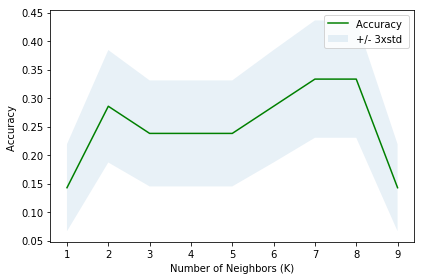

In [198]:
#now plot the results to see
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [199]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.333333333333 with k= 7


In [200]:
#rerun model using K=7
k = 7
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_trainKNN,y_trainKNN)
#predict test set
yhatKNN = neigh.predict(X_testKNN)
print("Train set Accuracy: ", metrics.accuracy_score(y_trainKNN, neigh.predict(X_trainKNN)))
print("Test set Accuracy: ", metrics.accuracy_score(y_testKNN, yhatKNN))

Train set Accuracy:  0.475
Test set Accuracy:  0.333333333333


In [201]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

#### Use the Pittsburgh data point as the real test data. What cluster in Toronto is it most like?

In [217]:
## use the Pittsburgh data point as the real test. (Note poor accuracy of model)
Feature1 = pitts_grouped.drop(['Neighborhood'], axis=1)
Feature1.head(2)

,Accessories Store,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Bakery,Bar,Bistro,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Cocktail Bar,Coffee Shop,College Academic Building,Comedy Club,Concert Hall,Cosmetics Shop,Deli / Bodega,Diner,Dive Bar,Fast Food Restaurant,Gift Shop,Golf Course,Grocery Store,Gym,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Ice Cream Shop,Indie Movie Theater,Library,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Museum,New American Restaurant,Noodle House,Park,Pet Store,Pizza Place,Plaza,Pub,Record Shop,Restaurant,Sandwich Place,Shoe Store,Shopping Plaza,Spiritual Center,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Toy / Game Store,Trail,Turkish Restaurant,Women's Store
0,0.01,0.01,0.01,0.01,0.02,0.06,0.05,0.01,0.01,0.01,0.01,0.02,0.02,0.01,0.01,0.01,0.04,0.01,0.01,0.02,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.02,0.01,0.02,0.01,0.01,0.01,0.02,0.04,0.01,0.01,0.02,0.02,0.01,0.01,0.01,0.01,0.02,0.01,0.03,0.01,0.04,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.01,0.01,0.02,0.01


In [229]:
header_list = list(trunc_merge)
header_list.remove('Neighborhood')
header_list.remove('Cluster Labels')
header_list.remove('Airport')
header_list

['ATM',
 'Adult Boutique',
 'Afghan Restaurant',
 'Airport Lounge',
 'American Restaurant',
 'Antique Shop',
 'Aquarium',
 'Art Gallery',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Dealership',
 'Automotive Shop',
 'BBQ Joint',
 'Badminton Court',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Baseball Stadium',
 'Basketball Court',
 'Basketball Stadium',
 'Bath House',
 'Beach',
 'Beer Bar',
 'Beer Store',
 'Big Box Store',
 'Bike Shop',
 'Bistro',
 'Bookstore',
 'Boutique',
 'Bowling Alley',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Bridge',
 'Bubble Tea Shop',
 'Buffet',
 'Building',
 'Burger Joint',
 'Burrito Place',
 'Bus Station',
 'Butcher',
 'Café',
 'Cajun / Creole Restaurant',
 'Campground',
 'Candy Store',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Casino',
 'Castle',
 'Caucasian Restaurant',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Church',
 'Churrascaria',
 'Circus',
 'Climbing Gym

In [230]:
Feature1 = Feature1.reindex(columns = header_list)


In [231]:
Feature1.head()

,ATM,Adult Boutique,Afghan Restaurant,Airport Lounge,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Liquor Store,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,0.01,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.06,NaN,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.01,0.01,NaN,NaN,0.02,0.02,NaN,NaN,NaN,NaN,NaN,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.04,NaN,0.01,NaN,NaN,0.02,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [232]:
X1 = Feature1

In [233]:
X1 = X1.reset_index()
X1.shape

(1, 254)

In [234]:
X1.fillna(0, inplace = True)

In [235]:
yhatKNN_test = neigh.predict(X1)

### Squirrel Hill, Pittsburgh is closest to cluster number 2 in Toronto!

In [236]:
#This is the cluster in Toronto that the Squirrel Hill section of Pittsburgh most resembles:
yhatKNN_test

array([2], dtype=int32)

# Discussion

Toronto cluster number 2 is what I would call "Homey." It is predominately coffe shops and cafes, with a smattering of ethnic cuisine restaurants. There are few parks and hotels, a bit of shopping too. However, the venues appear to me to be more parochial -- not upscale and swank, not seedy or undesirable. 

Squirrel Hill in Pittsburgh has this same look. It is also a very low crime area. I can say from experience, having just visited both these places over winter holiday, that they have the same quaint feel. Less-rushed, but still modern neighborhoods. 

Squirrel Hill is dominated by Bakeries, Bars, and Ice Cream Shops. It has several pizza places, parks, grocery stores, and even some ethnic restaurants. Cluster 2 in Toronto has several Italian restaurants as well in the first and second most popular venues.

I believe the most successful restaurant in Squirrel Hill might be a more upscale Italian restaurant, a step up from pizza and more akin to ethnic cuisine.

I give you **Momma's Focaccia Ristorante!**


*Limitations.* This is a limited model, with an accurancy rate of 33% at the optimal k = 7. It is possible that other classification models will yield higher accuracy ratings, but these directional results are good enough to combine with a human perspective for a successful business launch.

# Conclusion

To improve this model, I would repeat this analysis with more external data. Neighborhood incomes, ethnic makeup, resident education levels, and types of local industry would all be added to a more advanced treatment of this subject. Hopefully, these other variables would improve the model's accuracy. 

# The End

## Appendix: Tried a few things, but couldn't get them to work

### Thornhill stuff (tried to pull in just Thornhill data. Needed all of Toronto, as above.)

In [ ]:
Thornhilldf = pd.DataFrame({'Neighborhood':['Thornhill'], 'Neighborhood Latitude':latitude_T, 'Neighborhood Longitude':longitude_T})
Thornhilldf

In [ ]:
##CALL FUNCTION
toronto_venues2 = getNearbyVenues(names=Thornhilldf['Neighborhood'],
                                   latitudes=Thornhilldf['Neighborhood Latitude'],
                                   longitudes=Thornhilldf['Neighborhood Longitude']
                                  )

In [ ]:
print(toronto_venues2.shape)
toronto_venues2.head()

In [ ]:
##SEE COUNT OF EACH ELEMENT IN TABLE
toronto_venues2.groupby('Neighborhood').count()

In [ ]:
##HOW MANY UNIQUE
print('There are {} uniques categories.'.format(len(toronto_venues2['Venue Category'].unique())))

In [ ]:
##ONE HOT ENCODING FOR K MEANS CLUSTERING
toronto_onehot2 = pd.get_dummies(toronto_venues2[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
toronto_onehot2['Neighborhood'] = toronto_venues2['Neighborhood'] 
mid = toronto_onehot2['Neighborhood']
toronto_onehot2.drop(labels=['Neighborhood'], axis=1,inplace = True)
toronto_onehot2.insert(0, 'Neighborhood', mid)
# move neighborhood column to the first column
#fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
#toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot2.head()

In [ ]:
toronto_onehot.shape

In [ ]:
##GROUP 'EM
toronto_grouped2 = toronto_onehot2.groupby('Neighborhood').mean().reset_index()
toronto_grouped2

In [ ]:
toronto_onehot2.shape

In [ ]:
##DEFINE TOP 10 VENUES--BOTH TORONTO AND PITTS
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

In [ ]:
# create columns according to number of top venues--BOTH TORONTO AND PITTS
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [ ]:
# create a new dataframe TORONTO
T_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
T_neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped2['Neighborhood']

for ind in np.arange(toronto_grouped2.shape[0]):
    T_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped2.iloc[ind, :], num_top_venues)

T_neighborhoods_venues_sorted

### Attempted to categorize the venues. Couldn't complete the code, so went in a similar, but other, direction.)

In [ ]:
#append df to create rollup categories of venues
combodf = toronto_venues.append(pitts_venues, ignore_index = True)
combodf.shape

In [ ]:
#get unique Venue Category
a = combodf['Venue Category'].unique()
sorted(a)

In [ ]:
df = pd.DataFrame(a,columns=['Venue Category']).sort_values('Venue Category').reset_index(drop=True)
df

In [ ]:
#create function for rollup
def rollUp(venue):
    
    americ=['American Restaurant', 'Bistro', 'Burger Joint', 'Deli / Bodega', 'Fast Food Restaurant', 'Hot Dog Joint', 'New American Restaurant', 'Sandwich Place', \
            'Seafood Restaurant', 'Vegetarian / Vegan Restaurant', 'Wings Joint']
    asian=['Asian Restaurant', 'Cantonese Restaurant', 'Dumpling Restaurant', 'Hong Kong Restaurant', 'Japanese Restaurant', 'Korean Restaurant', 'Noodle House', \
           'Ramen Restaurant', 'Shanghai Restaurant', 'Sushi Restaurant', 'Szechuan Restaurant', 'Taiwanese Restaurant', 'Thai Restaurant','Vietnamese Restaurant']
    bar=['Bar', 'Brewery', 'Cocktail Bar', 'Dive Bar', 'Pub']
    deleteme=['Accessories Store', 'Art Museum', 'Arts & Crafts Store', 'Auto Dealership', 'Bookstore', 'Botanical Garden', 'Boutique', 'College Academic Building', \
               'Comedy Club', 'Concert Hall', 'Cosmetics Shop', 'Department Store', 'Furniture / Home Store', 'Gift Shop',  'Golf Course', 'Grocery Store', \
               'Gym', 'Health Food Store', 'Historic Site', 'History Museum', 'Hobby Shop', 'Hotel', 'Indie Movie Theater', 'Library', 'Liquor Store', 'Movie Theater', \
               'Museum', 'Paper / Office Supplies Store', 'Park', 'Pet Store', 'Plaza', 'Record Shop', 'Shoe Store', 'Shopping Plaza', 'Spiritual Center', 'Supermarket', \
               'Supplement Shop', 'Toy / Game Store', 'Trail', "Women's Store", 'Yoga Studio']
    diner=['Bagel Shop', 'Bakery', 'Breakfast Spot', 'Bubble Tea Shop', 'Café', 'Coffee Shop', 'Creperie', 'Dessert Shop', 'Diner', 'Ice Cream Shop', 'Tea Room']
    mideast=['Greek Restaurant', 'Restaurant', 'Doner Restaurant', 'Hookah Bar', 'Mediterranean Restaurant', 'Middle Eastern Restaurant', 'Turkish Restaurant']
    pizza=['Italian Restaurant', 'Pizza Place']
    tex=['Burrito Place', 'Mexican Restaurant']
    
    if venue in americ:
        return("American")
    elif venue in asian:
        return("Asian")
    elif venue in bar:
        return("Bar")
    elif venue in deleteme:
        return("deleteme")
    elif venue in diner:
        return("Diner")
    elif venue in mideast:
        return("MiddleEastern")
    elif venue in pizza:
        return("Pizza")
    elif venue in tex:
        return("TexMex")
    else:
        return("zzNotFound")

In [ ]:
venue = 'Mexican'
rollUp(venue)

In [ ]:
test = pitts_venues
test.head()

In [ ]:
americ=['American Restaurant', 'Bistro', 'Burger Joint', 'Deli / Bodega', 'Fast Food Restaurant', 'Hot Dog Joint', 'New American Restaurant', 'Sandwich Place', \
            'Seafood Restaurant', 'Vegetarian / Vegan Restaurant', 'Wings Joint']
asian=['Asian Restaurant', 'Cantonese Restaurant', 'Dumpling Restaurant', 'Hong Kong Restaurant', 'Japanese Restaurant', 'Korean Restaurant', 'Noodle House', \
           'Ramen Restaurant', 'Shanghai Restaurant', 'Sushi Restaurant', 'Szechuan Restaurant', 'Taiwanese Restaurant', 'Thai Restaurant','Vietnamese Restaurant']
bar=['Bar', 'Brewery', 'Cocktail Bar', 'Dive Bar', 'Pub']
deleteme=['Accessories Store', 'Art Museum', 'Arts & Crafts Store', 'Auto Dealership', 'Bookstore', 'Botanical Garden', 'Boutique', 'College Academic Building', \
               'Comedy Club', 'Concert Hall', 'Cosmetics Shop', 'Department Store', 'Furniture / Home Store', 'Gift Shop',  'Golf Course', 'Grocery Store', \
               'Gym', 'Health Food Store', 'Historic Site', 'History Museum', 'Hobby Shop', 'Hotel', 'Indie Movie Theater', 'Library', 'Liquor Store', 'Movie Theater', \
               'Museum', 'Paper / Office Supplies Store', 'Park', 'Pet Store', 'Plaza', 'Record Shop', 'Shoe Store', 'Shopping Plaza', 'Spiritual Center', 'Supermarket', \
               'Supplement Shop', 'Toy / Game Store', 'Trail', "Women's Store", 'Yoga Studio']
diner=['Bagel Shop', 'Bakery', 'Breakfast Spot', 'Bubble Tea Shop', 'Café', 'Coffee Shop', 'Creperie', 'Dessert Shop', 'Diner', 'Ice Cream Shop', 'Tea Room']
mideast=['Greek Restaurant', 'Restaurant', 'Doner Restaurant', 'Hookah Bar', 'Mediterranean Restaurant', 'Middle Eastern Restaurant', 'Turkish Restaurant']
pizza=['Italian Restaurant', 'Pizza Place']
tex=['Burrito Place', 'Mexican Restaurant']




rollup=[]
for row in test['Venue Category']:
    if row in pizza:
        rollup.append["PizzaPizza"]

        
test['Roll-up'] = rollup       


data = [{'Venue_Category': 'Italian'},
       {'Venue_Category': 'Pizza'},
        {'Venue_Category': 'Pasta'},
        {'Venue_Category': 'Park'},
        {'Venue_Category': 'Gym'},
        {'Venue_Category': 'School'}]
df = pd.DataFrame(data)
df